## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 512
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.4, 0.8]
redice_lr_patient = [5, 8]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.40, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 5s 101us/step - loss: 0.7129 - acc: 0.7764 - val_loss: 1.4637 - val_acc: 0.5097
Epoch 46/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.7127 - acc: 0.7768 - val_loss: 1.4639 - val_acc: 0.5108
Epoch 47/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.7128 - acc: 0.7772 - val_loss: 1.4640 - val_acc: 0.5104
Epoch 48/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.7121 - acc: 0.7762 - val_loss: 1.4644 - val_acc: 0.5102
Epoch 49/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.7116 - acc: 0.7773 - val_loss: 1.4643 - val_acc: 0.5101

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.6384001355618238e-06.
Epoch 50/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.7110 - acc: 0.7785 - val_loss: 1.4643 - val_acc: 0.5100
Numbers of exp: 1, reduce_factor: 0.40, reduce_patient: 8
______________________________________

50000/50000 [==============================] - 5s 102us/step - loss: 2.1799 - acc: 0.2663 - val_loss: 2.2055 - val_acc: 0.2584
Epoch 43/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.1746 - acc: 0.2674 - val_loss: 2.1999 - val_acc: 0.2597
Epoch 44/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.1690 - acc: 0.2700 - val_loss: 2.1946 - val_acc: 0.2609
Epoch 45/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.1629 - acc: 0.2703 - val_loss: 2.1895 - val_acc: 0.2627
Epoch 46/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.1556 - acc: 0.2704 - val_loss: 2.1838 - val_acc: 0.2643
Epoch 47/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.1508 - acc: 0.2741 - val_loss: 2.1789 - val_acc: 0.2662
Epoch 48/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.1470 - acc: 0.2747 - val_loss: 2.1740 - val_acc: 0.2674
Epoch 49/50
50000/50000 [==============

50000/50000 [==============================] - 5s 102us/step - loss: 2.1909 - acc: 0.2512 - val_loss: 2.2024 - val_acc: 0.2531
Epoch 41/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.1835 - acc: 0.2539 - val_loss: 2.1966 - val_acc: 0.2550
Epoch 42/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.1770 - acc: 0.2555 - val_loss: 2.1909 - val_acc: 0.2571
Epoch 43/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.1716 - acc: 0.2588 - val_loss: 2.1857 - val_acc: 0.2588
Epoch 44/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.1653 - acc: 0.2598 - val_loss: 2.1799 - val_acc: 0.2600
Epoch 45/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.1592 - acc: 0.2607 - val_loss: 2.1743 - val_acc: 0.2607
Epoch 46/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.1543 - acc: 0.2630 - val_loss: 2.1689 - val_acc: 0.2621
Epoch 47/50
50000/50000 [==============

50000/50000 [==============================] - 5s 102us/step - loss: 2.2328 - acc: 0.2545 - val_loss: 2.2502 - val_acc: 0.2531
Epoch 39/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.2273 - acc: 0.2541 - val_loss: 2.2434 - val_acc: 0.2554
Epoch 40/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.2217 - acc: 0.2571 - val_loss: 2.2371 - val_acc: 0.2563
Epoch 41/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.2137 - acc: 0.2580 - val_loss: 2.2313 - val_acc: 0.2569
Epoch 42/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.2069 - acc: 0.2589 - val_loss: 2.2256 - val_acc: 0.2586
Epoch 43/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.2014 - acc: 0.2615 - val_loss: 2.2195 - val_acc: 0.2602
Epoch 44/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.1959 - acc: 0.2622 - val_loss: 2.2141 - val_acc: 0.2614
Epoch 45/50
50000/50000 [==============

50000/50000 [==============================] - 6s 123us/step - loss: 0.4267 - acc: 0.8788 - val_loss: 1.5055 - val_acc: 0.5388
Epoch 34/50
50000/50000 [==============================] - 6s 123us/step - loss: 0.4240 - acc: 0.8807 - val_loss: 1.5086 - val_acc: 0.5390
Epoch 35/50
50000/50000 [==============================] - 6s 124us/step - loss: 0.4235 - acc: 0.8809 - val_loss: 1.5071 - val_acc: 0.5405
Epoch 36/50
50000/50000 [==============================] - 6s 124us/step - loss: 0.4207 - acc: 0.8811 - val_loss: 1.5122 - val_acc: 0.5401

Epoch 00036: ReduceLROnPlateau reducing learning rate to 4.09600033890456e-06.
Epoch 37/50
50000/50000 [==============================] - 6s 125us/step - loss: 0.4181 - acc: 0.8830 - val_loss: 1.5102 - val_acc: 0.5395
Epoch 38/50
50000/50000 [==============================] - 6s 123us/step - loss: 0.4171 - acc: 0.8839 - val_loss: 1.5101 - val_acc: 0.5407
Epoch 39/50
50000/50000 [==============================] - 6s 124us/step - loss: 0.4155 - acc: 0.8

50000/50000 [==============================] - 6s 128us/step - loss: 1.8806 - acc: 0.3518 - val_loss: 1.9434 - val_acc: 0.3370
Epoch 30/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.8733 - acc: 0.3532 - val_loss: 1.9376 - val_acc: 0.3383
Epoch 31/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.8662 - acc: 0.3561 - val_loss: 1.9314 - val_acc: 0.3389
Epoch 32/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.8600 - acc: 0.3577 - val_loss: 1.9257 - val_acc: 0.3416
Epoch 33/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.8542 - acc: 0.3596 - val_loss: 1.9201 - val_acc: 0.3420
Epoch 34/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.8462 - acc: 0.3622 - val_loss: 1.9143 - val_acc: 0.3438
Epoch 35/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.8421 - acc: 0.3629 - val_loss: 1.9096 - val_acc: 0.3446
Epoch 36/50
50000/50000 [==============

50000/50000 [==============================] - 6s 124us/step - loss: 1.8843 - acc: 0.3516 - val_loss: 1.9331 - val_acc: 0.3423
Epoch 28/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.8770 - acc: 0.3545 - val_loss: 1.9271 - val_acc: 0.3451
Epoch 29/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.8692 - acc: 0.3551 - val_loss: 1.9213 - val_acc: 0.3457
Epoch 30/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.8635 - acc: 0.3572 - val_loss: 1.9153 - val_acc: 0.3478
Epoch 31/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.8563 - acc: 0.3603 - val_loss: 1.9101 - val_acc: 0.3498
Epoch 32/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.8505 - acc: 0.3605 - val_loss: 1.9045 - val_acc: 0.3501
Epoch 33/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.8449 - acc: 0.3629 - val_loss: 1.9000 - val_acc: 0.3521
Epoch 34/50
50000/50000 [==============

50000/50000 [==============================] - 6s 123us/step - loss: 1.9028 - acc: 0.3458 - val_loss: 1.9608 - val_acc: 0.3337
Epoch 26/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.8940 - acc: 0.3497 - val_loss: 1.9541 - val_acc: 0.3353
Epoch 27/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.8859 - acc: 0.3513 - val_loss: 1.9468 - val_acc: 0.3366
Epoch 28/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.8780 - acc: 0.3533 - val_loss: 1.9394 - val_acc: 0.3395
Epoch 29/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.8717 - acc: 0.3549 - val_loss: 1.9334 - val_acc: 0.3411
Epoch 30/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.8652 - acc: 0.3571 - val_loss: 1.9275 - val_acc: 0.3434
Epoch 31/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.8571 - acc: 0.3596 - val_loss: 1.9218 - val_acc: 0.3461
Epoch 32/50
50000/50000 [==============

50000/50000 [==============================] - 6s 114us/step - loss: 0.5581 - acc: 0.8181 - val_loss: 1.4890 - val_acc: 0.5326
Epoch 23/50
50000/50000 [==============================] - 6s 114us/step - loss: 0.5451 - acc: 0.8241 - val_loss: 1.5006 - val_acc: 0.5341
Epoch 24/50
50000/50000 [==============================] - 6s 114us/step - loss: 0.5320 - acc: 0.8294 - val_loss: 1.5143 - val_acc: 0.5323
Epoch 25/50
50000/50000 [==============================] - 6s 114us/step - loss: 0.5208 - acc: 0.8337 - val_loss: 1.5186 - val_acc: 0.5335

Epoch 00025: ReduceLROnPlateau reducing learning rate to 6.40000042039901e-05.
Epoch 26/50
50000/50000 [==============================] - 6s 114us/step - loss: 0.4911 - acc: 0.8457 - val_loss: 1.5150 - val_acc: 0.5338
Epoch 27/50
50000/50000 [==============================] - 6s 114us/step - loss: 0.4842 - acc: 0.8500 - val_loss: 1.5099 - val_acc: 0.5364
Epoch 28/50
50000/50000 [==============================] - 6s 114us/step - loss: 0.4785 - acc: 0.8

Epoch 17/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.1742 - acc: 0.2670 - val_loss: 2.1910 - val_acc: 0.2693
Epoch 18/50
50000/50000 [==============================] - 6s 115us/step - loss: 2.1547 - acc: 0.2731 - val_loss: 2.1730 - val_acc: 0.2732
Epoch 19/50
50000/50000 [==============================] - 6s 115us/step - loss: 2.1386 - acc: 0.2769 - val_loss: 2.1568 - val_acc: 0.2783
Epoch 20/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.1200 - acc: 0.2812 - val_loss: 2.1425 - val_acc: 0.2820
Epoch 21/50
50000/50000 [==============================] - 6s 115us/step - loss: 2.1027 - acc: 0.2874 - val_loss: 2.1282 - val_acc: 0.2867
Epoch 22/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.0877 - acc: 0.2910 - val_loss: 2.1145 - val_acc: 0.2902
Epoch 23/50
50000/50000 [==============================] - 6s 115us/step - loss: 2.0733 - acc: 0.2953 - val_loss: 2.1017 - val_acc: 0.2924
Epoch 24/50
50000/50000 [==

50000/50000 [==============================] - 6s 114us/step - loss: 2.1844 - acc: 0.2581 - val_loss: 2.2174 - val_acc: 0.2581
Epoch 16/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.1628 - acc: 0.2630 - val_loss: 2.1962 - val_acc: 0.2646
Epoch 17/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.1426 - acc: 0.2673 - val_loss: 2.1769 - val_acc: 0.2704
Epoch 18/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.1221 - acc: 0.2738 - val_loss: 2.1589 - val_acc: 0.2745
Epoch 19/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.1045 - acc: 0.2799 - val_loss: 2.1423 - val_acc: 0.2791
Epoch 20/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.0873 - acc: 0.2841 - val_loss: 2.1269 - val_acc: 0.2827
Epoch 21/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.0721 - acc: 0.2870 - val_loss: 2.1121 - val_acc: 0.2853
Epoch 22/50
50000/50000 [==============

50000/50000 [==============================] - 6s 114us/step - loss: 2.1988 - acc: 0.2602 - val_loss: 2.2187 - val_acc: 0.2618
Epoch 14/50
50000/50000 [==============================] - 6s 116us/step - loss: 2.1740 - acc: 0.2675 - val_loss: 2.1952 - val_acc: 0.2686
Epoch 15/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.1534 - acc: 0.2717 - val_loss: 2.1748 - val_acc: 0.2746
Epoch 16/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.1312 - acc: 0.2794 - val_loss: 2.1560 - val_acc: 0.2778
Epoch 17/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.1117 - acc: 0.2845 - val_loss: 2.1383 - val_acc: 0.2830
Epoch 18/50
50000/50000 [==============================] - 6s 115us/step - loss: 2.0953 - acc: 0.2889 - val_loss: 2.1228 - val_acc: 0.2878
Epoch 19/50
50000/50000 [==============================] - 6s 114us/step - loss: 2.0778 - acc: 0.2942 - val_loss: 2.1073 - val_acc: 0.2907
Epoch 20/50
50000/50000 [==============

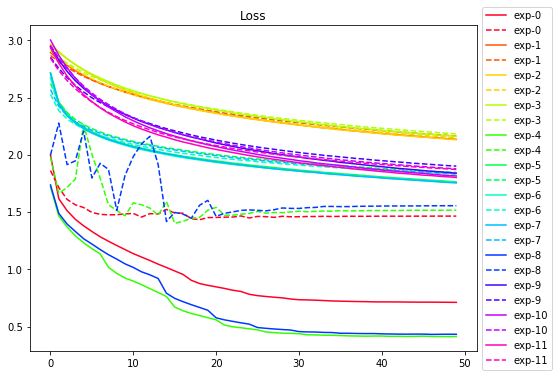

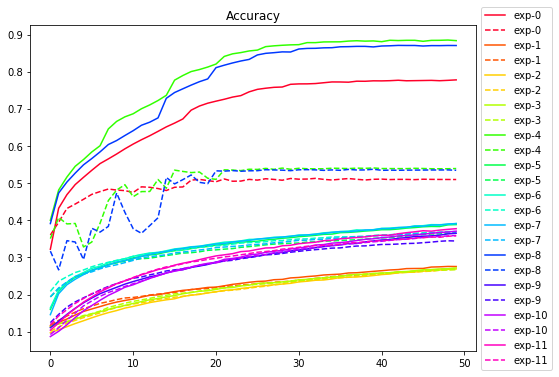

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()